#  Advanced Lane Detection 

This project aims to detect the vehicle lane (Ego lane) by detecting its lane lines and then projecting a polynomial of the lane onto the image, to achieve this I'll be using these files and methods:
1. [`adv_laneline_detection.py`](./adv_laneline_detection.py) which contains the pipeline and all of its main methods
2. [`P4`](./P4.ipynb) a notebook that has a walk through of the project, trains a model, and implements the pipeline on the project videos.
3. [`kerasmodel.py`](./kerasmodel.py)
4. [`utils.py`](./utils.py)

and other files that will be included in the project files.

##  Camera Calibration

This step is important for not all cameras reflect the real correct aspects of the real world, to calibrate out camera images we'll need to take some image of an object with notable spatial properties in this case a chess checkered board. OpenCV has predefined methods that can help us calibrate our images by providing multiple images of a chess board skldjfkl sjda lsd
in our case we were given 20 calibration images to calibrate our camera with, not all of the images work because OpenCV only finds the chessboard corners for images that have the whole board in view.

![all_camera_calibration_images.png](./images/all_camera_calibration_images.png)

I calculated the corners using the OpenCV 

![all_calibration_corner_images.png](./images/all_calibration_corner_images.png)

Then I used the images provided to undistort the camera images as you can see below:

![undistort.png](./images/undistort.png)

The images are lks
djfklsdj

Now we have an undistorted images the next step is to extract lane line features using different thresholding techniques.

## The Pipeline (Computer Vision)

**Note:** The main pipeline can be found starting from *line `603`* in the [`adv_laneline_detection.py`](./adv_laneline_detection.py) file and also as a walk though at [`P4`](./P4.ipynb)


### Undistort the Image
The first set of the pipeline is to undistort the image using the undistortion matrix we obtained from calibrating our camera, here are examples of undistorted images:

![after_undistortion.png](./images/after_undistortion.png)

## Thresholding 

In this project I combined color and gradient thresholding techniques to try and get the best lane lines fit possible.

### Color Thresholds
I tried out multiple color spaces, but settled on `RGB` and `HLS` the `R` and the `S` channels to be exact.

![undistorted_combined_color_images.png](./images/undistorted_combined_color_images.png)

I tried out different color thresholds for each and combined them using `combined_color_thresh()` method at *line `142`* of [`adv_laneline_detection.py`](./adv_laneline_detection.py), but I had a problem with shadows and the thickness of the yellow line which would though off the curvature, after some investigation I found out that the *Red* channel was the culprit. So I kept tweaking red channel threshold, and in the end I had to set its threshold to a very high narrow range `220-250` thresholds.

### Gradient Thresholds

Here I used a combination of absolute (x and y), magnitude, and directional sobel gradients to get the best possible estimation of image edges, I combined the thresholds using the `combined_sobel_thresh()` method which you can find in [`adv_laneline_detection.py`](./adv_laneline_detection.py) *line `227`*. I tried out different thresholds, but ended up using these thresholds:

| Sobel        | Thresholds   | 
|:-------------:|:-------------:| 
| Absolute      | 20, 100        | 
| Magnitude     | 70, 100      |
| Directional   | 1.1, 1.3      |

Here is an image that demonstrates the sobel gradients:
![combined_sobel_images.png](./images/combined_sobel_images.png)


### Combined Gradient 

I proceeded to try and get the best of both worlds by further combining the color and sobel gradient thresholded images, and the result is as shown here:

![combined_color_sobel_images.png](./images/combined_color_sobel_images.png)


## Perspective Transform 
Now that we have a good representation of the lane lines we'll need to look at the images from a different perspective or point of view for the lack of a better word in order to fit to detect and fit a polynomial to the detected lines. Here I warped the undistorted thresholded image using using these source and destination points: 

|Position       | Source        | Destination   | 
|:-------------:|:-------------:|:-------------:| 
|Top-Left| width * 0.45, height * 0.63      | image_offset, 0 | 
|Bottom-Left| width * 0.10, height * 0.95     | image_offset, height     |
|Top-Right| width * 0.94, height * 0.95   | width - image_offset, height  | 
|Bottom-Right| width * 0.56, height * 0.63   | width - image_offset , 0     |

**Note:** The `height` and `width` are the image's height and width, and the `image_offset` is `10` and I also used `100` and `200`.

In [ ]:
# Source
[width * 0.45, height * 0.63] # Top left vertix 60% if the image's hight
[width * 0.10, height * 0.95] # Bottom left
[width * 0.94, height * 0.95] # Bottom right 
[width * 0.56, height * 0.63] # Top right vetrix

In [ ]:
# Destination
[image_offset, 0]              # Top left
[image_offset, height]         # Bottom left
[width - image_offset, height] # Bottom right
[width - image_offset , 0]     # Top right

I used the `adv_laneline_detection.warp_and_transform_image()` method located on the `117th line` of the [`adv_laneline_detection.py`](./adv_laneline_detection.py) file to warp the image. 

Here are some lane lines project warped images:

![project_undistorted_warped_images.png](./images/project_undistorted_warped_images.png)

## Smoothing

I applied Gaussian blur to smoothen the images which significantly improved the results by removing a lot of noise and smoothing the lane lines.

##  Sliding Window

Lets now locate the lane lines in the bird's eye view images, for this I used a sliding window and also used convolutions to maximize the chances of getting the right fit.  

First I calculated the window centroids by using the `find_window_centroids()` which you can find at *line `407`* of the [`adv_laneline_detection.py`](./adv_laneline_detection.py) file. 
I tried out different window parameters, but ultimately  chose 
* `50` window width which is wide enough for the lanes
* `5` vertical layers or levels to search through the image 
* A margin of `100` which is great for not going too far off lane 

After detecting the centroids calculated the windows I used the `draw_lines_windows()` on line *line `462`* of the [`adv_laneline_detection.py`](./adv_laneline_detection.py) file to get windows indieces and draw them onto a copy of the warped image. 


##  Polyfit and Drivable Area


**Note:** You can check the [`P4`](./P4.ipynb) section *Detect Lane Lines and Fit Polynomial* for the Polyfit and Drivable Area demonstration.

All we need now is to fit a polynomial to our detected lane lines windows to get a final representation of our lane lines, I used the `polyfit_lines()` method at *line `505`* to fit two polynomials to the lane. 

Then I created lines based on the polynomials using `compute_polyfit()`  * line`514`*.

Finally I drew a drivable area between the detected polynomials, unwarped(transformed it back) the image using `Minv` (an inverse matrix of the warping one) then projected it onto the original undistorted image which looked something like this:

![drawn_drivable_area.png](./images/drawn_drivable_area.png) 

Also here is the warped image with its windows and poltfits alongside the final result:
![1.png](./images/1.png)

##  Calculate Curvature

One final thing remains which is calculating the lane curvature to check if we've detected a viable lane line. Here I used 

`get_curvature()` method which can be found on *line number `538`*, this method uses `get_rad_curv()` at *line `529`* to not only calculate the curvature, but calculate it for real space as in *meters* rather than *pixels*. Generally the curvature should be near `1000` where a maximum of `1600` for example is tolerated for the maximum curvature for the video according to google maps is `1000m`, but we might get a number which is slightly off. 

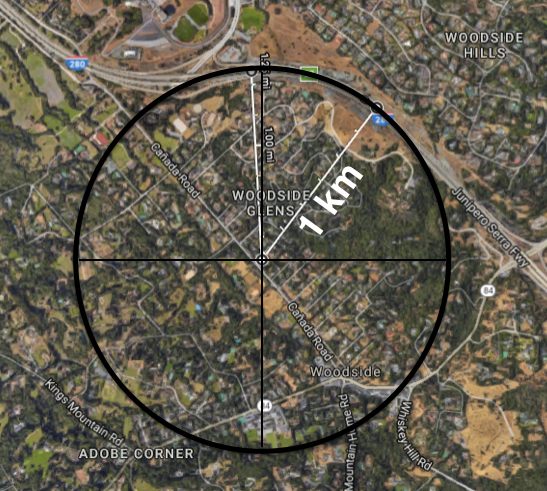


There is also the case of the straight line where curvature values go bananas to over `10,000`.


# Using A ConvNet

So as we've seen so far we can get pretty decent results with the computer vision techniques used above, however, its very hard to generalize to multiple cases as is the case for the challenge videos, but even harder to adapt it in the real world where lane lines aren't always the indicator of a drivable area. For the reasons mentioned above I sought out to take advantage of the power of deep learning, so I thought of using Deep Conv nets to draw a drivable area by teaching a model to do so. The Idea first came from the Behavioral Cloning Project where I trained the simulator to drive through 2 tracks using an model Nvidia which worked great, then after I joined the Lyft Segmentation Challenge while working on this project I met a lot of amazing students the likes of Eric Lavigne who actually used ConvNets to detect lanelines and cars on the road for the P4 and P5 projects. After working on SegNets for the challenge the idea was clearer and then using SegNet came into fruition.

### Advantages
* Speed
* Generalization
* Detecting anylies

### Disadvantages
* Requires a lot of data 
* Training time




## SegNet

I used a variant of [SegNet](http://mi.eng.cam.ac.uk/projects/segnet/) architecture, this model proved useful during the lyft challenge so I reused it for this project.

SegNet is a *FCN*(Fully Convolutional Network) that means that if you input an image you still get an image as a result. SegNet uses an auto encoder architecture where it has `5` encoder blocks that **shrink* the image and **extract** more features as we go deeper and a decoder which **upsamples** the image and **decrease** its features till it gets an image the same size as the input image, but this time it has a **softmax image** of the image labels.

I used the *VGG16 imagenet* pre-trained weights as the encoder, ignored *VGG16* fully connected layers, froze the weights to keep them constant while training, that will serve as my SegNet encoder. Then I added a mirroring decoder which is what will be trained on the new images.


![segnet.png](./images/segnet.png)


## Implementation 

The SegNet implementation `segnet()` can be found starting from  *line `138`* in [`kerasmodel.py`](./kerasmodel.py).

**Note:** All model code can be found at [`kerasmodel.py`](./kerasmodel.py).



## Data Collection and Preparation

I got the training data form the **Berekely Diverse Driving Video Database bdd100k** which was suggested by Michael Virgo, this database has many annotations which is appropriate for the segmentation task at hand. I combined Car segment images with the driving area segments and ended up with `3,425` images which is not much, so I applied a couple of augmentations to increase the number to `16,440` after a `20%` train test split. Then I combined the labels from different label images into a final 3 channel label image where the first channel (0) has the drivable area pixels, the second channel contains the car pixels, and the final channel had all other pixels as you can see here:

![final_labels.png](./images/final_labels.png)


I also manually labeled `53` images that I extracted extracted from the 3 project videos, I chose normal frames as well as some outliers like extreme brightness as is the case in the harder challenge video. Its a labor intensive process, but it was worth the effort for the `53` images helped the model on the videos after I retrained the network on the images.
I used a program called **Pixel Annotation Tool** which is basically a fancy paint, I also wrote a couple of scripts to combine images from different folders and to copy car and drivable area pixels from different label images to a single combined label image.

I also resized all of the training images and labels to `256x256` for a faster training and inception time.


## Training 

For training I did that on 2 times, the first was training the model on the `3,425` *bdd100k* dataset, then I trained the model on the manually extracted and labeled `53` images which was `264` after the validation split and augmentation. The mentioned approach added more accuracy for most of the videos, but it slightly overfit the small training data which made the model lack in certain areas where it previously hadn't, though it's still improved the overall performance.

### Additions
I'm planing to use more images to make the model more robust, in particular the CVPR_2018 data which has a combination of different datasets Cityspace for example.  



# Videos

## Computer Vision Outputs

### [Project Video](./videos/project_video_CV.mp4)
### [Challenge Video](./videos/challenge_video_CV.mp4)
### [Harder Challenge Video](./videos/harder_challenge_video_CV.mp4)


## SegNet Outputs

### [Project Video](./videos/project_video_model_main.mp4)
### [Challenge Video](./videos/challenge_video_model_main.mp4)
### [Harder Challenge Video](./videos/harder_challenge_video_model_main.mp4)

# Conclusion 
This project was fun and challenging, but I think that I got my finger in the right approach which is using *Conv nets* to identify the lane and other objects in the scene. I've had a lot of help and guidance from different people which made this project really special and I'll work on improving it in the weeks to come. I couldn't do more for the time being because I'm really late in submitting the project, but that won't stop me from improving, I hope. Thank you for checking out the project and if anyone has any suggestions or questions drop me a link.

#  Potential Shortcomings 
1. The lane area is not stable
2. The segmentation result is not accurate
3. Compute the car relative to the center of the road

# Suggested Solutions
1. Average the lines over multiple frames
2. Add more training data to get better segmentation results

# Future Improvements

1. Average the lines over multiple frames, I already have the framework in place, so I'll implemented in the coming weeks 
2. Increase the model robustness.
3. Compute the car relative to the center of the road

## Improvements
1. Calculated and added the car position in lane
2. Added the suggested color spaces and thresholds to the overall threshold which improved the performance in bright and low light situations 
3. Checked If the distance between the lane lines are of a suitable lane size and discarded any fits that are below that limit. `adv_laneline_detection.average_lane_sampling` at *line `774`*
4. I also changed the window size to `100` which gave slightly better results, and I increased the number of windows to `6`.
5. I checked for difference in curvature for both lanes and if one is much higher than the other I mirror the other if its viable onto the faulty one .

## Notable Changes
* In `adv_laneline_detection.get_vehicle_position()` * line `570`*
* In `adv_laneline_detection.other_color_thresholds()` *line `128`*
* In `adv_laneline_detection.process_image()` * line `634`*

